This is probably a dumb idead but the ages have to be weighted by the volume over which they're computed 


Algorithm

    - Repeat for 1,000 steps:
        -Pick a volume parameter dt  --> look at the distribution of ages centered around (theta, dt)
        - Compute median age weighted by volume (assume theta ^3)
        - Save median age
        - Increase d theta
    - Return median ages weighted by the volume
    
    
    
   
Theta is a phase-space thing (position, velocit, actions, metallicity) 
Delta theta is a tunable parameter

As delta theta goes to infinity, prob --> 0
        

In [1]:
import quickage
import warnings
warnings.filterwarnings("ignore")

import astropy.coordinates as astro_coord
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import math
#from astropy.constants im
%matplotlib inline
import pandas as pd
import quickage

In [2]:
ross={'ra': 34.76599999999999,
              'dec':35.353388888888894,
              'pmra':(670.532, 0.042),
              'pmdec':( -427.412, 0.040),
              'distance':  (17.44, 0.012),
              'rv': (-27.80, 0.14)}

ross_metal= (-0.40, 0.12)

ross_age= (7.2, 3.7)

trapp={'ra': 346.6250957,
              'dec':-5.0428081,
              'pmra': (922.0 , 0.6),
              'pmdec': (-471.9, 0.9),
              'distance':  (12.49 , 0.18),
              'rv': (-51.688, 0.014)}
trapp_metal=(0.04 , 0.08)

trapp_age= (7.6, 2.2)

In [3]:
2.2/7.6

0.2894736842105263

In [4]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    #remove nans
    nans= np.logical_or(np.isnan(values), np.isnan(weights))
    values=values[~nans]
    weights=weights[~nans]
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

In [5]:
data=quickage.load_sharma_galah_sample()

In [6]:
#cut
cut= np.logical_and(data['abs_j_bstep']-data['abs_ks_bstep'] > 0.4,  data['abs_j_bstep'] < 2.5)

In [1]:
#make a giant cut
#mask metal poor, alpha enriched stars 
fig, ax=plt.subplots(figsize=(10, 6))
c=ax.scatter(data['abs_j_bstep'][~cut]- data['abs_ks_bstep'][~cut], \
             data['abs_j_bstep'][~cut], s=.1, c='k')
c=ax.scatter(data['abs_j_bstep'][cut]-data['abs_ks_bstep'][cut], \
             data['abs_j_bstep'][cut],  c=data.age_bstep[cut],\
             s=1., vmin=0, vmax=8, cmap='cividis', alpha=0.1)


#o.plot(ax=ax)
cbar=plt.colorbar(c)
ax.invert_yaxis()
cbar.ax.set(ylabel='Age (Gyr)')

ax.set( xlabel='J-Ks', ylabel=r'M$_J$')
ax.minorticks_on()

NameError: name 'plt' is not defined

In [8]:
giants=data[cut]

In [9]:
def draw_random_star(dataset='galah', nsample=1, weighted=False):
    
    #draw a random star
    df= data.sample(n=nsample).reset_index(drop=True)
    
    res_df=[]
    for index, row in df.iterrows():
        try:
            dist= 1000/np.random.normal(row.plx,row.eplx,  1000)

            sourc={'ra': row.ra, \
                      'dec': row.dec,
                      'pmra':( row.pmracosdec, np.abs(0.1*row.pmracosdec)),
                      'pmdec':(row.pmde,  np.abs(0.1*row.pmde)),
                      'distance': (np.nanmedian(dist), np.nanstd(dist)),
                      'rv':(row['rv'], np.abs(row['er_rv']))}

            metal=(row['fe_h'] , np.abs(row['e_fe_h']))

            res=quickage.estimate_age(sourc, metal, nsigma=1,  data_set=giants,\
                          select_by=['metallicity', 'actions'], fweights=50,  weighted=weighted)

            res_df.append({'real': row.age_bstep,
                           'real_unc': [row['e16_age_bstep'], row['e84_age_bstep']], 
                   'res_median': res['median_age'] ,
                    'res_unc': [res['std_age'][0], res['std_age'][1]]})
        except:
            pass
    return pd.DataFrame.from_records(res_df)

In [10]:
%%capture
x= draw_random_star(nsample=200, weighted=True)

In [11]:
#x.to_csv('../data_weighted_ages_metcuts_validation.txt', index=False)

No handles with labels found to put in legend.


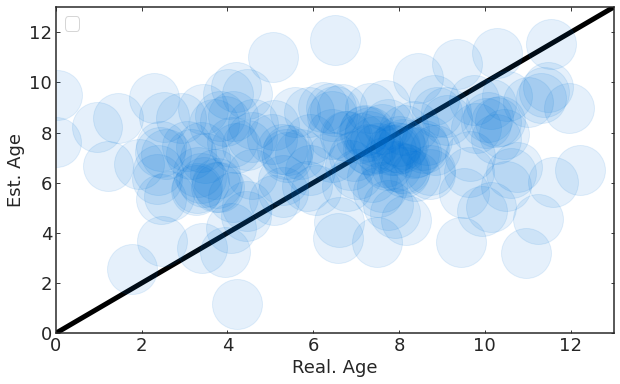

In [12]:
fig, ax=plt.subplots(figsize=(10, 6))

ax.errorbar(x['real'], x['res_median'], xerr=0, \
            yerr=0,  fmt='o',\
            c='#0074D9', ms=50, ecolor = '#0074D9', alpha=0.1)


#ax.errorbar(ross_age[0], ross_res[0], xerr= ross_age[1], yerr= ross_res[1],
#            fmt='o', c='#FF851B', ecolor = '#FF851B', label='ROSS 19')

#ax.errorbar(trapp_age[0], trap_res[0], xerr= trapp_age[1], yerr= trap_res[1],\
#            fmt='o', c='#FF4136', ecolor = '#FF4136', label='Trappist 1')

ax.legend()
ax.plot([0., 13], [0, 13], c='k', linewidth=5)
ax.set(xlim=[0, 13], ylim=[0, 13])
ax.set(xlabel='Real. Age', ylabel='Est. Age')
plt.savefig('weighted_ages_metcuts.jpeg')

In [13]:
#binned ages
dt=0.5
bins=np.arange(0, 13, dt)
binned=[]
for b in bins:
    boole= np.logical_and(x.real>=b, x.real<b+dt)
    binned.append([np.nanmedian(x.res_median[boole].values), np.nanstd((x.res_median[boole].values))])

No handles with labels found to put in legend.


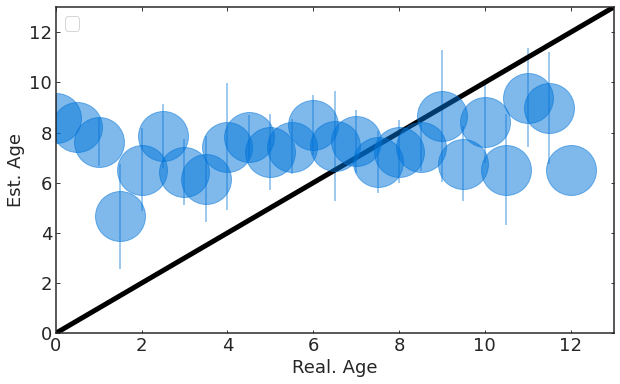

In [14]:
fig, ax=plt.subplots(figsize=(10, 6))

ax.errorbar(bins, np.vstack(binned)[:,0], yerr= np.vstack(binned)[:,1], fmt='o',\
            c='#0074D9', ms=50, ecolor = '#0074D9', alpha=0.5)


ax.legend()
ax.plot([0., 13], [0, 13], c='k', linewidth=5)
ax.set(xlim=[0, 13], ylim=[0, 13])
ax.set(xlabel='Real. Age', ylabel='Est. Age')
plt.savefig('weighted_ages_metcuts_binned.jpeg')